# Table of Contents

- [Initial Configuration](#Initial-Configuration)
- [Familiar Economy](#Familiar-Economy)
- [House and Air Conditionings](#House-and-Air-Conditionings)
- [Stock Control](#Stock-Control)
- [Useful life](#Useful-life)
- [Foxes and Rabbits](#Foxes-and-Rabbits)

# Initial Configuration

In [1]:
# General Purpose
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [2]:
plt.style.use('bmh')

In [3]:
import sympy as sy
from collections import namedtuple

fields = [
    "equilibrium_x",
    "equilibrium_y",
    "natural_frequency",
    "damping_ratio",
    "decay_rate",
]
AnalysisResults = namedtuple('AnalysisResults', fields)


def analyse(function):
    x, y = sy.symbols('x, y', positive=True)
    equations = sy.Matrix(function([x, y], 0))
    
    equilibrium_solutions = sy.solve(sy.Eq(equations, sy.Matrix([0, 0])), [x, y], dict=True)
    equilibrium_solutions = equilibrium_solutions[0] if len(equilibrium_solutions) else equilibrium_solutions
    x_equilibrium = equilibrium_solutions[x]
    y_equilibrium = equilibrium_solutions[y]
    
    jacobian = equations.jacobian([x, y])
    
    jacobian_at_equilibrium = jacobian.subs({x: x_equilibrium, y: y_equilibrium})
    
    eigenvalues = sy.Matrix(list(jacobian_at_equilibrium.eigenvals()))
    
    decay_rate = abs(sy.re(eigenvalues)[0])
    
    natural_frequency = abs(sy.im(eigenvalues)[0])
    
    damping_ratio = decay_rate / (decay_rate**2 + natural_frequency**2)**0.5
    
    return AnalysisResults(
        x_equilibrium,
        y_equilibrium,
        natural_frequency,
        damping_ratio,
        decay_rate
    )

In [4]:
import os
import pickle
import pprint
import time
from collections import defaultdict
from datetime import datetime

import pandas as pd
import sympy as sy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import clear_output

In [5]:
def round_expr(expr, num_digits=5):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sy.Number)})

In [6]:
def plot_vector_field(xs, ys, function, *, ax):
    X1 , Y1  = np.meshgrid(xs, ys)          # create a grid
    DX1, DY1 = function([X1, Y1], 0)        # compute growth rate on the grid
    M = np.hypot(DX1, DY1)                  # norm growth rate 
    M[ M == 0] = 1.                         # avoid zero division errors 
    DX1 /= M                                # normalize each arrows
    DY1 /= M
    M /= 2
    
    cmap = ListedColormap(sns.color_palette("Greens_r", 50)[:-20])
    ax.streamplot(X1, Y1, DX1, DY1, density=1.5, color=M, cmap=cmap)

In [7]:
def plot_normal_vectors(xs, ys, function, *, ax, skip=15, **kwargs):
    xs_, ys_ = xs[::skip], ys[::skip]
    
    dsdt = np.array(function([xs_, ys_], 0))
    norm = np.hypot(*dsdt)
    dsdt /= norm
    
    ax.quiver(xs_, ys_, *dsdt, scale=kwargs.pop("scale"), scale_units="x", **kwargs)

In [8]:
def compute_nullclines(xs, delta, independent_variable, dependable_variable, *, invert=False):
    solution = sy.solve(sy.Eq(delta, 0), dict=True)

    nullcline_, *_ = solution
    nullcline = nullcline_.get(independent_variable)

    if not nullcline:
        nullcline = nullcline_.get(dependable_variable)
        invert = True
    
    if not invert:
        evaluate = np.vectorize(sy.utilities.lambdify(dependable_variable, nullcline))
        ys = evaluate(xs)
        return xs, ys, nullcline
    
    if not nullcline.free_symbols:
        constant = float(sy.N(nullcline))
        xs = np.ones_like(xs) * constant
        ys = np.linspace(0, constant * 2, 1000)
        return xs, ys, nullcline
        
    nullclines = sy.solve(nullcline - independent_variable, dependable_variable)
    nullcline = nullclines[0] if len(nullclines) else nullclines
    evaluate = np.vectorize(sy.utilities.lambdify(independent_variable, nullcline))
    ys = evaluate(xs)
    return xs, ys, nullcline
    
def plot_nullclines(xs, delta, independent_variable, dependable_variable, function, *, ax, invert=False, **kwargs):
    xs, ys, nullcline = compute_nullclines(xs, delta, independent_variable, dependable_variable, invert=invert)
    
    skip = kwargs.pop("skip")
    scale = kwargs.pop("scale")

    label = f"{dependable_variable}-Nullcline - $dx/dt=0 \Rightarrow f(x): {round_expr(nullcline)}$"
    ax.plot(xs, ys, label=label, ls="--", lw=2, **kwargs)

    plot_normal_vectors(xs, ys, function, ax=ax, skip=skip, scale=scale, color=kwargs.get("color"), width=.0025)

In [9]:
def plot_equilibrium(dsdt, first_variable, second_variable, *, ax):
    equilibrium = sy.solve(dsdt, first_variable, second_variable, dict=True)
    equilibrium = equilibrium[0] if len(equilibrium) else equilibrium
    first_fix_point = equilibrium[first_variable]
    second_fix_point = equilibrium[second_variable]
    
    label = f"Fix Point at $x={first_fix_point:2.2f}; y={second_fix_point:2.2f}$"
    ax.scatter(first_fix_point, second_fix_point, s=100, color="gold", ls="--", label=label)

In [10]:
def plot_field_and_nullclines(function, *, xlim=(0.01, 50), ylim=(0, 50), sample_size=1000, scale=0.75, x_skip=15, y_skip=45):
    xs = np.linspace(*xlim, sample_size)
    ys = np.linspace(*ylim, sample_size)
    
    x, y = sy.symbols('x, y', positive=True)
    
    system_at_equilibrium = function([x, y], 0)
    x_at_equilibrium, y_at_equilibrium = system_at_equilibrium
    
    fig, ax = plt.subplots(figsize=(16, 5))
    
    plot_vector_field(xs, ys, function, ax=ax)
    
    plot_nullclines(xs, x_at_equilibrium, y, x, function, ax=ax, skip=x_skip, color="royalblue", scale=scale)
    
    plot_nullclines(xs, y_at_equilibrium, x, y, function, ax=ax, invert=True, skip=y_skip, color="firebrick", scale=scale)
    
    plot_equilibrium(system_at_equilibrium, x, y, ax=ax)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [11]:
def compute_envelope(xs, variable, initial_condition, equilibrium, initial_condition_delta, analysis_results):
    C1, C2, t = sy.symbols('C1 C2 t')

    exponential_decay = sy.exp(-analysis_results.decay_rate*t)
    periodic_oscillation = C1 * sy.cos(analysis_results.natural_frequency*t) + C2 * sy.sin(analysis_results.natural_frequency*t)
    offset = equilibrium
    general_solution_form = exponential_decay * periodic_oscillation + offset

    initial_condition_equation = sy.Eq(general_solution_form.subs(t, 0), initial_condition)

    C1_solution = float(sy.solve(initial_condition_equation, C1)[0])
    
    general_solution_first_derivative_at_initial_time = sy.diff(general_solution_form, t).subs(t, 0)

    C2_equation = sy.Eq(general_solution_first_derivative_at_initial_time, initial_condition_delta)

    C2_solution = float(sy.solve(C2_equation.subs(C1, C1_solution), C2)[0])

    amplitude = np.sqrt((C1_solution) ** 2 + (C2_solution) ** 2)
    
    envelope_exponential_decay = amplitude * np.exp(-xs * float(analysis_results.decay_rate))
    
    upper_envelop = offset + envelope_exponential_decay
    lower_envelop = offset - envelope_exponential_decay
    return upper_envelop, lower_envelop

# Familiar Economy

In [12]:
def main(initial_salary, savings_ration, extraordinary_expenses, fixed_costs, days):
    saving_limit = savings_ration * initial_salary
    
    def function(capital, time):
        if capital <= saving_limit:
            out_rate = 0
        else:
            out_rate = extraordinary_expenses * (capital - saving_limit)
        return -fixed_costs - out_rate
    
    time = np.linspace(0, days, days*10)
    
    solution = odeint(function, initial_salary, time)
    
    #Graphic details
    fig, ax = plt.subplots(figsize=(16, 5))    
    
    ax.plot((0, days), (saving_limit, saving_limit), label='Saving Limit')
    ax.plot(time, solution, label='Capital(t)')
    
    if days <= 60:
        step = 1
        rotation = "horizontal"
    elif days <= 300:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"
    
    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
    
    ax.set_yticks(np.arange(0, initial_salary * 1.1, initial_salary / 10))
    
    ax.set_xlim([0, days])
    ax.set_ylim([0, initial_salary * 1.1])
    ax.set_xlabel('Days')
    ax.set_ylabel('Capital $')
    ax.legend(loc='best', ncol=2)

    plt.tight_layout()
    plt.show()

interact(main, initial_salary=IntSlider(min=0, max=25000, step=500, value=15000, description='Initial Salary', style=style, layout=slider_layout),
               savings_ration=FloatSlider(min=0, max=1, step=0.01, value=0.2, description='Savings Ratio', style=style, layout=slider_layout),
               extraordinary_expenses=FloatSlider(min=0, max=1, step=0.005, description='Extraordinary Expenses', style=style, value=0.3, layout=slider_layout),
               fixed_costs=IntSlider(min=1, max=1000, step=1, value=100, description='Fixed Costs', style=style, layout=slider_layout),
               days=IntSlider(min=1, max=600, step=5, value=30, description='Total Number of Days', style=style, layout=slider_layout)
        );

interactive(children=(IntSlider(value=15000, description='Initial Salary', layout=Layout(width='99%'), max=250…

# House and Air Conditionings

In [13]:
def main(initial_houses, initial_ac, avg_time_house, avg_time_ac, total_houses, days):

    def function(s, time):
        x, y = s
        dydt = [
            (1 / avg_time_house) * (total_houses - x), # dx/dt: Change in the House sales
            (1 / avg_time_ac) * (x - y) # dx/dt: Change in the AC sales
        ]
        return dydt
    
    time = np.linspace(0, days, days * 10)
    initial_conditions = [initial_houses, initial_ac]
    solution = odeint(function, initial_conditions, time)

    analysis = analyse(function)
    damping_ratio = analysis.damping_ratio

    #Graphic details
    fig, ax = plt.subplots(figsize=(16, 5))
 
    ax.plot(time, solution[:, 0], label='Houses(t)')
    ax.plot(time, solution[:, 1], label='Air Conditionings(t)')
    ax.plot((0, days), (total_houses, total_houses), label='Total Houses')
    
    if days <= 60:
        step = 1
        rotation = "horizontal"
    elif days <= 300:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"
    
    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
    
    ax.set_yticks(np.arange(0, total_houses * 1.1, total_houses / 20))

    ax.set_xlim([0, days])
    ax.set_ylim([0, total_houses * 1.1])
    ax.set_xlabel('Months')
    ax.set_ylabel('Units')
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"Damping Ratio: $\zeta={damping_ratio:.2f}$"]
    ax.legend(handles, labels, loc='best', ncol=4)
    
    plt.tight_layout()
    plt.show()

interact(main, initial_houses=IntSlider(min=0, max=2000, step=10, value=0, description='Initial sold Houses', style=style, layout=slider_layout),
               initial_ac=IntSlider(min=0, max=2000, step=10, value=0, description='Initial sold AC', style=style, layout=slider_layout),
               total_houses=IntSlider(min=1, max=2000, step=100, value=1000, description='Total Houses', style=style, layout=slider_layout),
               avg_time_house=FloatSlider(min=0.1, max=24, step=0.1, value=2, description='Time for House', style=style, layout=slider_layout),
               avg_time_ac=FloatSlider(min=0.1, max=24, step=0.1, value=4, description='Time for AC', style=style, layout=slider_layout),
               days=IntSlider(min=1, max=360, step=10, value=30, description='Total Number of Days', style=style, layout=slider_layout),
        );

interactive(children=(IntSlider(value=0, description='Initial sold Houses', layout=Layout(width='99%'), max=20…

In [14]:
def main(avg_time_house, avg_time_ac, total_houses):

    def function(s, time):
        x, y = s
        dydt = [
            (1 / avg_time_house) * (total_houses - x), # dx/dt: Change in the House sales
            (1 / avg_time_ac) * (x - y) # dx/dt: Change in the AC sales
        ]
        return dydt
    
    plot_field_and_nullclines(function, xlim=(900, 1100), ylim=(900, 1100), scale=.1, x_skip=10, y_skip=25)

interact(
    main, 
    total_houses=IntSlider(min=1, max=2000, step=100, value=1001, description='Total Houses', style=style, layout=slider_layout),           
    avg_time_house=FloatSlider(min=0.1, max=24, step=0.1, value=2, description='Time for House', style=style, layout=slider_layout),           
    avg_time_ac=FloatSlider(min=0.1, max=24, step=0.1, value=4, description='Time for AC', style=style, layout=slider_layout),           
);

interactive(children=(FloatSlider(value=2.0, description='Time for House', layout=Layout(width='99%'), max=24.…

# Stock Control

In [15]:
def main(desired_stock, initial_stock, initial_request, stock_control, market_demand, provider_delay, days):
    
    def function(v0, time):
        x, y = v0
        dydt = [
            (1 / provider_delay) * y - market_demand, # dx/dt -> Change in Stock
          - (1 / provider_delay) * y + market_demand + stock_control * (desired_stock - x) # dy/dt -> Change in Requests
        ]
        return dydt
    
    time = np.linspace(0, days, days * 10)
    initial_conditions = [initial_stock, initial_request]
    initial_stock_delta, initial_request_delta = function([initial_stock, initial_request], 0)
    
    solution = odeint(function, initial_conditions, time)
    stocks, requests = solution.T

    analysis_results = analyse(function)
    stock_equilibrium = analysis_results.equilibrium_x
    requests_equilibrium = analysis_results.equilibrium_y
    

    #Graphic details
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    ax = axes[0]

    
    ax.plot(time, stocks, label='Stock(t)', color="royalblue")
    stock_upper_envelope, stock_lower_envelope = compute_envelope(time, x, initial_stock, stock_equilibrium, initial_stock_delta, analysis_results)
    ax.plot(time, stock_upper_envelope, color="royalblue", ls="--")
    ax.plot(time, stock_lower_envelope, color="royalblue", ls="--")

    
    ax.plot(time, requests, label='Requests(t)', color="firebrick")
    requests_upper_envelope, requests_lower_envelope = compute_envelope(time, y, initial_request, requests_equilibrium, initial_request_delta, analysis_results)
    ax.plot(time, requests_upper_envelope, color="firebrick", ls="--")
    ax.plot(time, requests_lower_envelope, color="firebrick", ls="--")
    
    ax.plot((0, days), (desired_stock, desired_stock), label='Desired Stock')
    
    if days <= 60:
        step = 1
        rotation = "horizontal"
    elif days <= 300:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"

    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
    
    ax.set_xlim([0, days])
    ax.set_ylim([0, solution.max() * 1.05])
    ax.set_xlabel('Days')
    ax.set_ylabel('Units')
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"Damping Ratio: $\zeta={float(analysis_results.damping_ratio):.2f}$"]

    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"Decay Rate: $\lambda={float(analysis_results.decay_rate):.2f}$"]

    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"Natural Frequency: $\omega_n={float(analysis_results.natural_frequency):.2f}$"]
    
    ax.legend(handles, labels, loc='best')

    ax = axes[1]

    ax.plot(stocks, requests, label='Stocks vs Requests')
    ax.set_xlabel('Stocks')
    ax.set_ylabel('Requests')
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

## Interactive

interactive(children=(IntSlider(value=5, description='Desired Stock', layout=Layout(width='99%'), min=1, style…

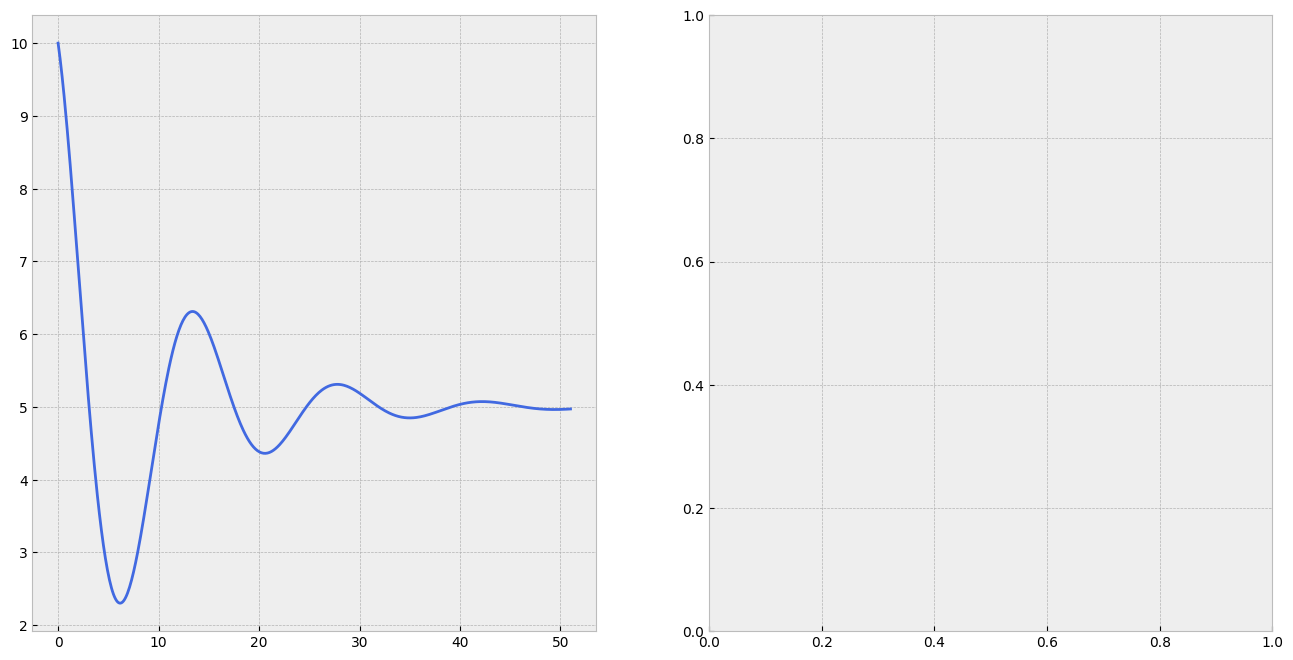

In [16]:
interact(
    main,
    desired_stock=IntSlider(min=1, max=100, step=1, value=5, description='Desired Stock', style=style, layout=slider_layout),
    initial_stock=IntSlider(min=1, max=100, step=1, value=10, description='Initial Stock', style=style, layout=slider_layout),
    initial_request=IntSlider(min=1, max=100, step=1, value=20, description='Initial Requests', style=style, layout=slider_layout),
    stock_control=FloatSlider(min=0, max=2, step=0.001, value=1, description='Stock Control', style=style, layout=slider_layout),
    market_demand=FloatSlider(min=0, max=24, step=0.01, value=5, description='Market Demand', style=style, layout=slider_layout),
    provider_delay=FloatSlider(min=0, max=10, step=0.1, value=5, description='Provider Delay', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=51, description='Total Number of Days', style=style, layout=slider_layout),
);

In [17]:
initial_request = 6
initial_stock = 8
days = 60

## Underdamped

NameError: name 'x' is not defined

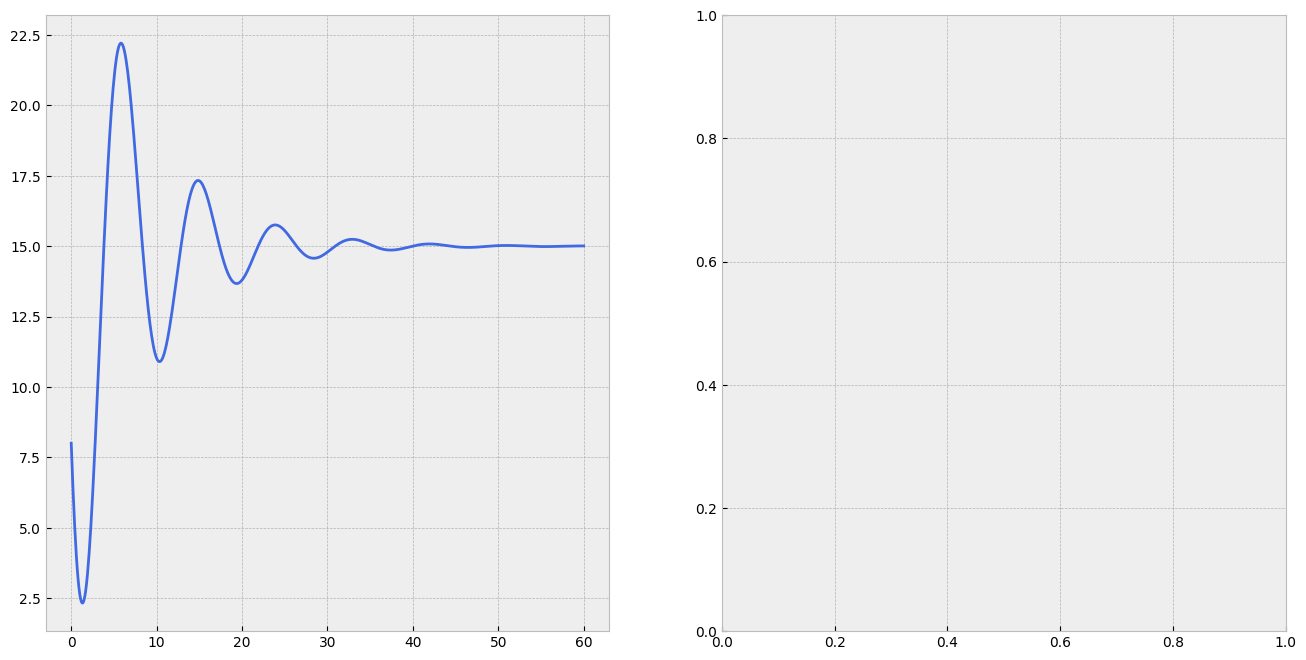

In [18]:
main(
    stock_control=2,
    provider_delay=4,
    desired_stock=15,
    market_demand=10,
    initial_request=initial_request,
    initial_stock=initial_stock,
    days=days,
);

## Critically Damped

In [ ]:
main(
    stock_control=0.04,
    provider_delay=4,
    desired_stock=25,
    market_demand=10,
    initial_request=initial_request,
    initial_stock=30,
    days=days,
);

## Critically Damped - Special Case - Equilibrium at same point

This happpens when the desired stock is the same value as the equilibrium point of the requests

In [ ]:
main(
    stock_control=0.04,
    provider_delay=4,
    desired_stock=40,
    market_demand=10,
    initial_request=initial_request,
    initial_stock=30,
    days=days*2,
);

## Real Condition - Two degrees of freedom fewer

Provider delay and market demand are outside of the control of the system

If those values are fixed, can critically damped behaviour be achieved?

In [ ]:
provider_delay = 10
market_demand = 10

### Underdamped

In [ ]:
main(
    stock_control=0.3,
    provider_delay=provider_delay,
    desired_stock=50,
    market_demand=market_demand,
    initial_request=initial_request,
    initial_stock=30,
    days=days,
);

### Critically Damped

In [ ]:
main(
    stock_control=0.025,
    provider_delay=provider_delay,
    desired_stock=50,
    market_demand=market_demand,
    initial_request=initial_request,
    initial_stock=100,
    days=days*3,
);

### Automatic Computation

In [ ]:
def safe_solve(equation: sy.Eq, initial_points: np.ndarray[float] = np.logspace(-4, 1, 20)) -> float:
    """Solves an equation with multiple initial points, skiping the ones that failed and returns the maxima)"""
    best = initial_points[0]
    for initial in initial_points:
        try:
            solution = sy.nsolve(equation, initial)
            best = max(best, solution)
        except:
            continue
    return best

In [ ]:
def compute_with_automatic_control(provider_delay: float, market_demand: float, desired_stock: int, initial_stock: int, days: int) -> None:
    stock_control = sy.symbols('stock_control', positive=True)

    def function(s, time):
        x, y = s
        dydt = [
            (1 / provider_delay) * y - market_demand, # dx/dt -> Change in Stock
          - (1 / provider_delay) * y + market_demand + stock_control * (desired_stock - x) # dy/dt -> Change in Requests
        ]
        return dydt

    damping_ratio = analyse(function)["damping_ratio"]
    stock_control = safe_solve(sy.Eq(damping_ratio, 1))

    print(f"{stock_control = }")
    main(
        stock_control=stock_control,
        provider_delay=provider_delay,
        desired_stock=desired_stock,
        market_demand=market_demand,
        initial_request=initial_request,
        initial_stock=initial_stock,
        days=days,
    );

In [ ]:
interact(
    compute_with_automatic_control,
    desired_stock=IntSlider(min=1, max=200, step=1, value=50, description='Desired Stock', style=style, layout=slider_layout),
    initial_stock=IntSlider(min=1, max=200, step=1, value=100, description='Initial Stock', style=style, layout=slider_layout),
    initial_request=IntSlider(min=1, max=200, step=1, value=14, description='Initial Requests', style=style, layout=slider_layout),
    market_demand=FloatSlider(min=0, max=50, step=0.5, value=10, description='Market Demand', style=style, layout=slider_layout),
    provider_delay=FloatSlider(min=0, max=50, step=0.5, value=10, description='Provider Delay', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=180, description='Total Number of Days', style=style, layout=slider_layout),
);

## NullClines

In [ ]:
def main(desired_stock, stock_control, market_demand, provider_delay):

    def function(v0, time):
        x, y = v0
        dydt = [
            (1 / provider_delay) * y - market_demand, # dx/dt -> Change in Stock
          - (1 / provider_delay) * y + market_demand + stock_control * (desired_stock - x) # dy/dt -> Change in Requests
        ]
        return dydt

    plot_field_and_nullclines(function, scale=.5, x_skip=20, y_skip=10)

interact(
    main,
    desired_stock=IntSlider(min=1, max=100, step=1, value=25, description='Desired Stock', style=style, layout=slider_layout),
    stock_control=FloatSlider(min=0, max=5, step=0.001, value=1, description='Stock Control', style=style, layout=slider_layout),
    market_demand=FloatSlider(min=0, max=9, step=0.01, value=5, description='Market Demand', style=style, layout=slider_layout),
    provider_delay=FloatSlider(min=0, max=10, step=0.1, value=5, description='Provider Delay', style=style, layout=slider_layout),
);

# Useful life

In [ ]:
def main(useful_life, intake_mg, intake_interval, intake_number, hours):
    
    def function(y, t):
        return - (np.log(2) / useful_life) * y # dy/dt -> Change of mg 
    
    intake_hours = [intake_interval * i for i in range(intake_number - 1)]
    initial_condition = intake_mg
    times = []
    solutions = []
    
    for intake_time in intake_hours:
        time = np.arange(intake_time, intake_time + intake_interval, 0.1)
        solution = odeint(function, initial_condition, time)
        
        initial_condition = solution[-1] + intake_mg
        
        times.extend(time)
        solutions.extend(solution)
        
    
    intake_time = intake_hours[-1] + intake_interval
    time = np.arange(intake_time, intake_time + 10 * intake_interval, 0.1)
    solution = odeint(function, initial_condition, time)
    times.extend(time)
    solutions.extend(solution)
    
    #Graphic details
    fig, ax = plt.subplots(figsize=(16, 5))
    
    plt.plot(times, solutions, label='Concentration in the Body(t)')
    
    if hours <= 60:
        step = 1
        rotation = "horizontal"
    elif hours <= 300:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"
    
    ax.set_xticks(np.arange(0, hours + 1, step))
    ax.set_xticklabels(np.arange(0, hours + 1, step, dtype=int), rotation=rotation)
    
    ax.set_xlim([0, hours])
    ax.set_ylim([0, max(solutions) * 1.05])
    ax.set_xlabel('Hours')
    ax.set_ylabel('Concentration')
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

interact(main,        
        useful_life=FloatSlider(min=0, max=24, step=0.01, value=3.8, description='Useful Life (hs)', style=style, layout=slider_layout),
        intake_mg=FloatSlider(min=0, max=1, step=0.001, value=0.01, description='Miligrams per Intake', style=style, layout=slider_layout),
        intake_interval=FloatSlider(min=0, max=24, step=0.1, value=6, description='Hours between Intakes', style=style, layout=slider_layout),
        intake_number=IntSlider(min=1, max=20, step=1, value=4, description='Number of Intakes', style=style, layout=slider_layout),
        hours=FloatSlider(min=1, max=240, step=0.5, value=40, description='Total number of Hours', style=style, layout=slider_layout),
        );

# Foxes and Rabbits

## Lotka–Volterra

In [ ]:
def main(rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate, initial_rabbits, initial_foxes, days):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits
            foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
        ]
        
        return dydt
    
    time = np.arange(0, days, 0.1)
    initial_conditions = [initial_rabbits, initial_foxes]
    solution = odeint(function, initial_conditions, time)

    rabbits, foxes = solution.T

    analysis = analyse(function)
    damping_ratio = analysis["damping_ratio"]

    #Graphic details
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    ax = axes[0]
    
    ax.plot(time, rabbits, label='Rabbits(t)')
    ax.plot(time, foxes, label='Foxes(t)')
    
    if days <= 30:
        step = 1
        rotation = "horizontal"
    elif days <= 150:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"
    
    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
        
    ax.set_xlim([0, days])
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')

    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"Damping Ratio: $\zeta={damping_ratio:.2f}$"]
    ax.legend(handles, labels, loc='best')
    
    
    ax = axes[1]
    
    ax.plot(rabbits, foxes, label='Foxes vs Rabbits')

    ax.set_xlabel('Rabbits')
    ax.set_ylabel('Foxes')
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    
interact(main, rabbits_birthrate=FloatSlider(min=0, max=1, step=0.001, value=0.09, description='Birth Rate of Rabbits', style=style, layout=slider_layout),
               rabbits_deathrate=FloatSlider(min=0, max=1, step=0.000005, value=5.5e-5, description='Death Rate of Rabbits', style=style, layout=slider_layout),
               foxes_birthrate=FloatSlider(min=0, max=1, step=0.0000001, value=0.0003, description='Birth Rate of Foxes', style=style, layout=slider_layout),
               foxes_deathrate=FloatSlider(min=0, max=1, step=0.0005, value=0.936, description='Death Rate of Foxes', style=style, layout=slider_layout),
               initial_rabbits=FloatSlider(min=0 , max=10000, step=1, value=3000, description='Initial Rabbits', style=style, layout=slider_layout),
               initial_foxes=FloatSlider(min=0 , max=10000, step=25, value=1800, description='Initial Foxes', style=style, layout=slider_layout),
               days=FloatSlider(min=0 ,max=365 , step=10, value=360, description='Total number of Days', style=style, layout=slider_layout),
        );

### Analysis

In [ ]:
rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate = sy.symbols('rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate', positive=True)

def function(s, t):
    x, y = s
    dydt = [
        rabbits_birthrate * x - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits
        foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
    ]
    
    return dydt

In [ ]:
analyse(function)

### Undamped

In [ ]:
main(
    rabbits_birthrate=0.1,
    rabbits_deathrate=5.5e-5,
    foxes_birthrate=3.1e-4,
    foxes_deathrate=1,
    initial_rabbits=3000,
    initial_foxes=1800,
    days=360,
);

### Underdamped

In [ ]:
main(
    rabbits_birthrate=0.1,
    rabbits_deathrate=5.5e-5,
    foxes_birthrate=3.1e-4,
    foxes_deathrate=1,
    initial_rabbits=3000,
    initial_foxes=1800,
    days=360,
);

### Nullclines

In [ ]:
def main(rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits
            foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
        ]
        
        return dydt

    plot_field_and_nullclines(function, xlim=(2970, 3270), ylim=(1500, 1800), scale=.1, x_skip=20, y_skip=5)

interact(
    main, 
    rabbits_birthrate=FloatSlider(min=0, max=1, step=0.001, value=0.09, description='Birth Rate of Rabbits', style=style, layout=slider_layout),
    rabbits_deathrate=FloatSlider(min=0, max=1, step=0.000005, value=5.5e-5, description='Death Rate of Rabbits', style=style, layout=slider_layout),
    foxes_birthrate=FloatSlider(min=0, max=1, step=0.0000001, value=0.0003, description='Birth Rate of Foxes', style=style, layout=slider_layout),
    foxes_deathrate=FloatSlider(min=0, max=1, step=0.0005, value=0.936, description='Death Rate of Foxes', style=style, layout=slider_layout),
);

## Lotka–Volterra with bounded Growth

In [ ]:
def main(rabbits_birthrate, rabbits_deathrate, 
         foxes_birthrate, foxes_deathrate, 
         maximal_rabbits, initial_rabbits, initial_foxes, days):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x - rabbits_birthrate / maximal_rabbits * x**2 - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits 
            foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
        ]
        
        return dydt
    
    time = np.arange(0, days, 0.1)
    initial_conditions = [initial_rabbits, initial_foxes]
    solution = odeint(function, initial_conditions, time)
    
    rabbits = solution[:, 0]
    foxes = solution[:, 1]

    #Graphic details
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    ax = axes[0]
    
    ax.plot(time, rabbits, label='Rabbits(t)')
    ax.plot(time, foxes, label='Foxes(t)')
    
    if days <= 30:
        step = 1
        rotation = "horizontal"
    elif days <= 150:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"

    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
        
    ax.set_xlim([0, days])
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.legend(loc='best')
    
    ax = axes[1]
    
    ax.plot(rabbits, foxes, label='Foxes vs Rabbits')

    ax.set_xlabel('Rabbits')
    ax.set_ylabel('Foxes')
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

interact(main, rabbits_birthrate=FloatSlider(min=0, max=1, step=0.001, value=0.09, description='Birth Rate of Rabbits', style=style, layout=slider_layout),
               rabbits_deathrate=FloatSlider(min=0, max=0.005, step=0.000005, value=5.5e-5, description='Death Rate of Rabbits', style=style, layout=slider_layout),
               foxes_birthrate=FloatSlider(min=0, max=0.003, step=0.0000001, value=0.0003, description='Birth Rate of Foxes', style=style, layout=slider_layout),
               foxes_deathrate=FloatSlider(min=0, max=1, step=0.0005, value=0.936, description='Death Rate of Foxes', style=style, layout=slider_layout),
               initial_rabbits=FloatSlider(min=0 , max=10000, step=1, value=3000, description='Initial Rabbits', style=style, layout=slider_layout),
               initial_foxes=FloatSlider(min=0 , max=10000, step=25, value=1800, description='Initial Foxes', style=style, layout=slider_layout),
               maximal_rabbits=FloatSlider(min=0 , max=10000, step=100, value=10000, description='Maximal Rabbits', style=style, layout=slider_layout),
               days=FloatSlider(min=0 ,max=365 , step=10, value=360, description='Total number of Days', style=style, layout=slider_layout),
        );

In [ ]:
rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate, maximal_rabbits = sy.symbols('rabbits_birthrate, rabbits_deathrate, foxes_birthrate, foxes_deathrate, maximal_rabbits', positive=True)

def function(s, t):
    x, y = s
    dydt = [
        rabbits_birthrate * x - rabbits_birthrate / maximal_rabbits * x**2 - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits 
        foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
    ]
    
    return dydt

In [ ]:
# damping_ratio = analyse(function)["damping_ratio"]

In [ ]:
# damping_substitution = damping_ratio.subs({
#     # rabbits_birthrate: 0.1,
#     rabbits_deathrate:5.5e-5,
#     foxes_birthrate: 3.1e-4,
#     foxes_deathrate: 1,
#     maximal_rabbits: 10000
# })
# damping_substitution

In [ ]:
# n, d = sy.fraction(damping_substitution)
# n

In [ ]:
# sy.nsolve(sy.Eq(n, 0.001), rabbits_birthrate, 0.4)

In [ ]:
# sy.nsolve(sy.Eq(d, 0.001), rabbits_birthrate, 5)

In [ ]:
# damping_substitution >= 1

In [ ]:
# sy.reduce_inequalities([damping_substitution >= 1], rabbits_birthrate)

In [ ]:
# sy.nsolve(damping_substitution >= 1, rabbits_birthrate)

In [ ]:
main(
    rabbits_birthrate=0.1,
    rabbits_deathrate=5.5e-5,
    foxes_birthrate=3.1e-4,
    foxes_deathrate=1,
    initial_rabbits=3000,
    initial_foxes=1800,
    maximal_rabbits=10000,
    days=360,
);

### Nullclines

In [ ]:
def main(
    rabbits_birthrate: float, 
    rabbits_deathrate: float, 
    foxes_birthrate: float, 
    foxes_deathrate: float, 
    maximal_rabbits: int, 
):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x - rabbits_birthrate / maximal_rabbits * x**2 - rabbits_deathrate * x * y, # dx/dy -> Change in Rabbits 
            foxes_birthrate * x * y - foxes_deathrate * y # dy/dt -> Change in Foxes
        ]
        
        return dydt
    
    plot_field_and_nullclines(function, xlim=(2970, 3270), ylim=(975, 1275), scale=.1, x_skip=20, y_skip=2)

interact(
    main, 
    rabbits_birthrate=FloatSlider(min=0, max=1, step=0.001, value=0.09, description='Birth Rate of Rabbits', style=style, layout=slider_layout),           
    rabbits_deathrate=FloatSlider(min=0, max=0.005, step=0.000005, value=5.5e-5, description='Death Rate of Rabbits', style=style, layout=slider_layout),           
    foxes_birthrate=FloatSlider(min=0, max=0.003, step=0.0000001, value=0.0003, description='Birth Rate of Foxes', style=style, layout=slider_layout),           
    foxes_deathrate=FloatSlider(min=0, max=1, step=0.0005, value=0.936, description='Death Rate of Foxes', style=style, layout=slider_layout),           
    maximal_rabbits=FloatSlider(min=0 , max=10000, step=100, value=10000, description='Maximal Rabbits', style=style, layout=slider_layout),           
);

## R. M. May's Model

In [ ]:
def main(rabbits_birthrate, maximal_rabbits, rabbits_deathrate, predator_efficiency, foxes_birthrate, food_efficiency, initial_rabbits, initial_foxes, days):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x * (1 - x / maximal_rabbits) - (rabbits_deathrate * x * y) / (x + predator_efficiency), # dx/dy -> Change in Rabbits
            foxes_birthrate * y * (1 - y / (food_efficiency * x)) # dy/dt -> Change in Foxes
        ]
        
        return dydt
    
    time = np.arange(0, days, 0.05)
    initial_conditions = [initial_rabbits, initial_foxes]
    solution = odeint(function, initial_conditions, time)

    rabbits = solution[:, 0]
    foxes = solution[:, 1]

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    ax = axes[0]
    
    ax.plot(time, rabbits, label='Rabbits(t)')
    ax.plot(time, foxes, label='Foxes(t)')
    
    if days <= 30:
        step = 1
        rotation = "horizontal"
    elif days <= 150:
        step = 5
        rotation = "vertical"
    else:
        step = 10
        rotation = "vertical"
    
    ax.set_xticks(np.arange(0, days + 1, step))
    ax.set_xticklabels(np.arange(0, days + 1, step, dtype=int), rotation=rotation)
        
    ax.set_xlim([0, days])
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.legend(loc='best')
    
    ax = axes[1]
    
    ax.plot(rabbits, foxes, label='Foxes vs Rabbits')

    ax.set_xlabel('Rabbits')
    ax.set_ylabel('Foxes')
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
interact(main, rabbits_birthrate=FloatSlider(min=0, max=24, step=0.01, value=2, description='Birth Rate of Rabbits', style=style, layout=slider_layout),
               rabbits_deathrate=FloatSlider(min=0, max=10, step=0.01, value=5.5, description='Death Rate of Rabbits', style=style, layout=slider_layout),
               foxes_birthrate=FloatSlider(min=0, max=3, step=0.01, value=0.2, description='Birth Rate of Foxes', style=style, layout=slider_layout),
               predator_efficiency=FloatSlider(min=0, max=10, step=0.5, value=2, description='Predator Efficiency', style=style, layout=slider_layout),
               food_efficiency=FloatSlider(min=0, max=2, step=0.01, value=0.2, description='Food Eficiency of Foxes', style=style, layout=slider_layout),
               maximal_rabbits=FloatSlider(min=0, max=5000, step=1, value=1000, description='Maximal Rabbits', style=style, layout=slider_layout),
               initial_rabbits=FloatSlider(min=0 , max=1000, step=1, value=500, description='Initial Rabbits', style=style, layout=slider_layout),
               initial_foxes=FloatSlider(min=0 , max=1000, step=1, value=100, description='Initial Foxes', style=style, layout=slider_layout),
               days=FloatSlider(min=0 ,max=365*3 , step=10, value=360, description='Total number of Days', style=style, layout=slider_layout),
        );

### Nullclines

In [ ]:
def main(rabbits_birthrate, maximal_rabbits, rabbits_deathrate, predator_efficiency, foxes_birthrate, food_efficiency):

    def function(s, t):
        x, y = s
        dydt = [
            rabbits_birthrate * x * (1 - x / maximal_rabbits) - (rabbits_deathrate * x * y) / (x + predator_efficiency), # dx/dy -> Change in Rabbits
            foxes_birthrate * y * (1 - y / (food_efficiency * x)) # dy/dt -> Change in Foxes
        ]
        
        return dydt

    plot_field_and_nullclines(function, xlim=(300, 600), ylim=(70, 110), scale=.1, x_skip=20, y_skip=25)
    
interact(
    main, 
    rabbits_birthrate=FloatSlider(min=0, max=24, step=0.01, value=2, description='Birth Rate of Rabbits', style=style, layout=slider_layout),           
    rabbits_deathrate=FloatSlider(min=0, max=10, step=0.01, value=5.5, description='Death Rate of Rabbits', style=style, layout=slider_layout),           
    foxes_birthrate=FloatSlider(min=0, max=3, step=0.01, value=0.2, description='Birth Rate of Foxes', style=style, layout=slider_layout),           
    predator_efficiency=FloatSlider(min=0, max=10, step=0.5, value=2, description='Predator Efficiency', style=style, layout=slider_layout),           
    food_efficiency=FloatSlider(min=0, max=2, step=0.01, value=0.2, description='Food Eficiency of Foxes', style=style, layout=slider_layout),           
    maximal_rabbits=FloatSlider(min=0, max=5000, step=1, value=1000, description='Maximal Rabbits', style=style, layout=slider_layout),           
);